# UMAP on 20 Newsgroups with Normalized Compression Distance

[Jiang and co-workers](https://aclanthology.org/2023.findings-acl.426/) described using the [Normalized Compression Distance (NCD)](https://en.wikipedia.org/wiki/Normalized_compression_distance) with k-nearest neighbors classification as a light-weight alternative to deep learning for text classification. This got some attention from the ML community and as this is a subject [close to my heart](https://pubs.acs.org/doi/10.1021/ci600384z) so I am glad to see it getting another moment in the sun.

Can NCD be used as a distance measure for use with dimensionality reduction methods? Let's give it a go using the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset.

In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 564 ms (started: 2023-07-17 07:49:59 -07:00)


## Load the Dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset="all")

time: 1.19 s (started: 2023-07-17 07:49:59 -07:00)


## Calculate the Nearest Neighbors

**You probably don't want to do this**. I have saved the 150 nearest neighbors in the `data` folder of this repo so if you just want to do something with the similarities, you should skip to the `Read precomputed neighbors` below.

The biggest problem with calculating the nearest neighbors of the 20NG dataset is that none of the nearest neighbors methods I am familiar with (Annoy, hnsw, PyNNDescent, FAISS) allow for passing generic distance functions for text data. PyNNDescent comes closest because it allows for custom metric functions, but it validates that the internal data is float-valued. So we will have to do this the slow way: an all-pairs calculation. The slow part is the NCD calculation so I used a `ProcessPoolExecutor` to split the work up at the cost of a bit of extra memory usage. I also did not use a heap to store the neighbors: as the 20NG dataset contains less than 20,000 observations, it's not that big a deal to that number of floating point values and sort them.

In [3]:
import gzip
from concurrent.futures import ProcessPoolExecutor
from typing import Any, List, Optional, Tuple

import numpy as np


def calculate_ncd_chunk(args):
    data, x_lens, i, chunk_indices = args
    instance_i = data[i][0]
    ncds = []
    for j in chunk_indices:
        instance_j = data[j][0]
        xy_len = len(gzip.compress(" ".join([instance_i, instance_j]).encode()))
        max_len = max(x_lens[i], x_lens[j])
        min_len = min(x_lens[i], x_lens[j])
        ncd = (xy_len - min_len) / max_len
        ncds.append(ncd)
    return ncds


def ncd_knn(
    data: List[Tuple[str, Any]],
    k: int,
    chunk_size: Optional[int] = None,
    max_workers: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    n = len(data)

    if chunk_size is None:
        if max_workers is None:
            raise ValueError("Please specify max_workers when chunk_size is None")
        chunk_size = int(n / max_workers)
        print(f"Using chunk_size = {chunk_size}")

    distances = np.empty((n, k), dtype=np.float32)
    indices = np.empty((n, k), dtype=int)

    x_lens = np.array([len(gzip.compress(x.encode())) for x, _ in data])

    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        for i in range(n):
            neighbors_heap = np.empty(n, dtype=np.float32)
            chunks = [range(j, min(j + chunk_size, n)) for j in range(0, n, chunk_size)]
            futures = [
                ex.submit(calculate_ncd_chunk, (data, x_lens, i, chunk))
                for chunk in chunks
            ]
            for chunk, future in zip(chunks, futures):
                neighbors_heap[list(chunk)] = future.result()

            sorted_indices = np.argsort(neighbors_heap)
            indices[i] = sorted_indices[:k]
            distances[i] = neighbors_heap[indices[i]]

    return indices, distances

time: 29.9 ms (started: 2023-07-17 07:50:00 -07:00)


Running this on the 20NG data took me around **6 hours** so run this next step at your own risk:

In [4]:
# ng20_ncd_knn = ncd_knn(ng20, 150)

time: 743 µs (started: 2023-07-17 07:50:00 -07:00)


### Write out the neighbors

This is another step you probably don't need to do unless you ran the NCD code and want to save the neighbors data somewhere. The `drnb_home=Path.cwd().parent / "data"` parameter means it will overwrite the pre-saved neighbor data in the `data` folder, so you will probably want to change the `name` and/or `suffix` parameters to save it to a different file.

In [5]:
# from pathlib import Path

# from drnb.io import write_pickle

# ng20_nn_path = write_pickle(
#     ng20_ncd_knn,
#     name="ng20",
#     suffix="ncdnn",
#     drnb_home=Path.cwd().parent / "data",
#     compression="gzip",
# )

time: 2.18 ms (started: 2023-07-17 07:50:00 -07:00)


## Read precomputed neighbors

**You probably do want to do this**. Just read in the neighbor data I already calculated, which is in the `data` folder of this repo (a sibling folder of the `notebooks` folder). As long as you don't want more than the 150-nearest neighbors, this should be fine.

In [6]:
from pathlib import Path

from drnb.io import read_pickle

ng20_ncd_knn = read_pickle(
    name="ng20", suffix="ncdnn", drnb_home=Path.cwd().parent.parent / "data"
)

time: 212 ms (started: 2023-07-17 07:50:00 -07:00)


In [7]:
ng20_ncd_knn

(array([[    0,   333,  1154, ...,  8113, 11464,  9297],
        [    1,  8028,  6468, ..., 15207,  2715,  4847],
        [    2, 12577,  5478, ..., 13622, 10187, 15553],
        ...,
        [18843,  5531, 10762, ..., 10879, 12328, 17746],
        [18844, 11518, 18207, ...,  6020, 17514, 14356],
        [18845, 17662,  1303, ..., 12908, 10337,   666]]),
 array([[0.03220036, 0.6940966 , 0.7101968 , ..., 0.8211091 , 0.8211091 ,
         0.8211091 ],
        [0.02941176, 0.7166948 , 0.733564  , ..., 0.8217993 , 0.8217993 ,
         0.8217993 ],
        [0.0265252 , 0.6120938 , 0.7877984 , ..., 0.9236074 , 0.9236074 ,
         0.9236074 ],
        ...,
        [0.03397028, 0.6602972 , 0.6624204 , ..., 0.7898089 , 0.7898089 ,
         0.7898089 ],
        [0.02796272, 0.54327565, 0.5782857 , ..., 0.84287614, 0.84287614,
         0.84287614],
        [0.02683179, 0.75394845, 0.82146543, ..., 0.872033  , 0.872033  ,
         0.872033  ]], dtype=float32))

time: 7.49 ms (started: 2023-07-17 07:50:01 -07:00)


## Prepare the Nearest Neighbors for UMAP

In [8]:
from drnb.embed.umap.umap import umap_knn

ng20_nn = umap_knn(idx=ng20_ncd_knn[0][:, :15], dist=ng20_ncd_knn[1][:, :15])

/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDepr

time: 4.47 s (started: 2023-07-17 07:50:01 -07:00)


/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


## Run UMAP

In [9]:
from umap import UMAP

time: 781 µs (started: 2023-07-17 07:50:05 -07:00)


As we have already got the nearest neighbors, we don't actually need to pass any other data in. However, UMAP's validation will be unhappy if no data is provided to `fit_transform` , if it has a different number of samples to the neighbor data and if any value is `NaN`, so the most expedient way forward is to pass an `n x 1` array of zeros.

In [10]:
coords = UMAP(
    precomputed_knn=ng20_nn, force_approximation_algorithm=True, random_state=42
).fit_transform(np.zeros((len(newsgroups.data), 1), np.float32))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


time: 13.6 s (started: 2023-07-17 07:50:05 -07:00)


## Visualize the Results

I am going to use an internal plotting function that makes use of seaborn under the hood. To get the categories showing up properly I must do some slight housekeeping with the target and target names:

In [11]:
from drnb.util import codes_to_categories

description = codes_to_categories(
    newsgroups.target, newsgroups.target_names, col_name="description"
)
description

0                rec.sport.hockey
1        comp.sys.ibm.pc.hardware
2           talk.politics.mideast
3        comp.sys.ibm.pc.hardware
4           comp.sys.mac.hardware
                   ...           
18841                     sci.med
18842             sci.electronics
18843    comp.sys.ibm.pc.hardware
18844               comp.graphics
18845                   rec.autos
Name: description, Length: 18846, dtype: category
Categories (20, object): ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', ..., 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

time: 14.6 ms (started: 2023-07-17 07:50:19 -07:00)


Now we can finally take a look at the results...

In [12]:
from drnb.plot import sns_embed_plot

time: 3.49 s (started: 2023-07-17 07:50:19 -07:00)


<Axes: >

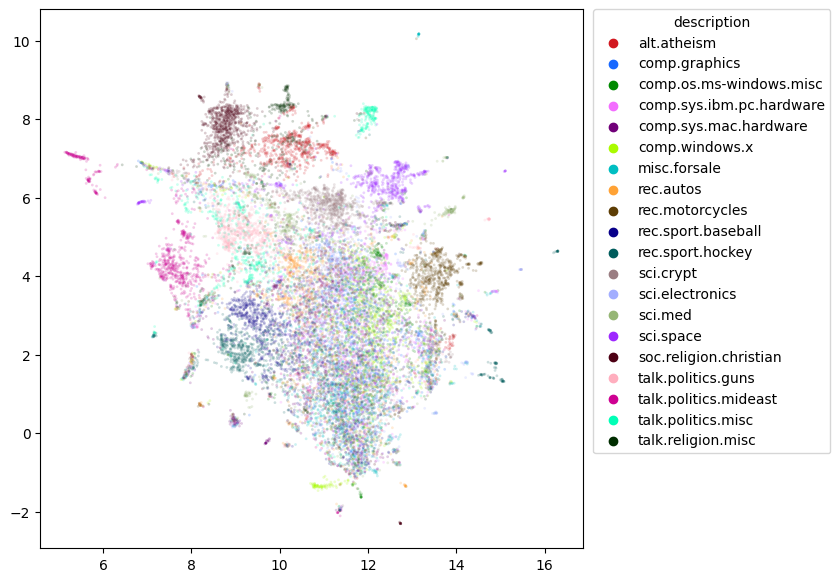

time: 1.94 s (started: 2023-07-17 07:50:22 -07:00)


In [13]:
sns_embed_plot(
    coords,
    color_col=description,
    cex=4,
    alpha_scale=0.2,
    legend="force",
    figsize=(7, 7),
)

That looks ok. I can see some actual clusters in there.

## Comparison with TF-IDF

As a comparison, let's look at running UMAP directly on the sparse [TF-IDF](https://umap-learn.readthedocs.io/en/latest/sparse.html) results. This uses the pre-vectorized results to save some time.

In [14]:
from sklearn.datasets import fetch_20newsgroups_vectorized
import sklearn.feature_extraction.text

time: 1.23 ms (started: 2023-07-17 07:50:24 -07:00)


In [15]:
newsgroups_vectorized = fetch_20newsgroups_vectorized(subset="all")

time: 788 ms (started: 2023-07-17 07:50:24 -07:00)


In [16]:
tfidf = sklearn.feature_extraction.text.TfidfTransformer(norm="l1").fit_transform(
    newsgroups_vectorized.data
)

time: 88.5 ms (started: 2023-07-17 07:50:25 -07:00)


The UMAP docs use `metric="hellinger"` for this step, but I get a `RuntimeWarning: invalid value encountered in sparse_correct_alternative_hellinger` so I am going to use boring old cosine instead. The results aren't hugely different.

In [17]:
tfidf_coords = UMAP(metric="cosine", random_state=42).fit_transform(tfidf)

time: 2min 41s (started: 2023-07-17 07:50:25 -07:00)


The `vectorized` data is in a different order to the `fetch_20newsgroups` results, so I need to run `codes_to_categories` again to get the cluster colors and legend correct:

<Axes: >

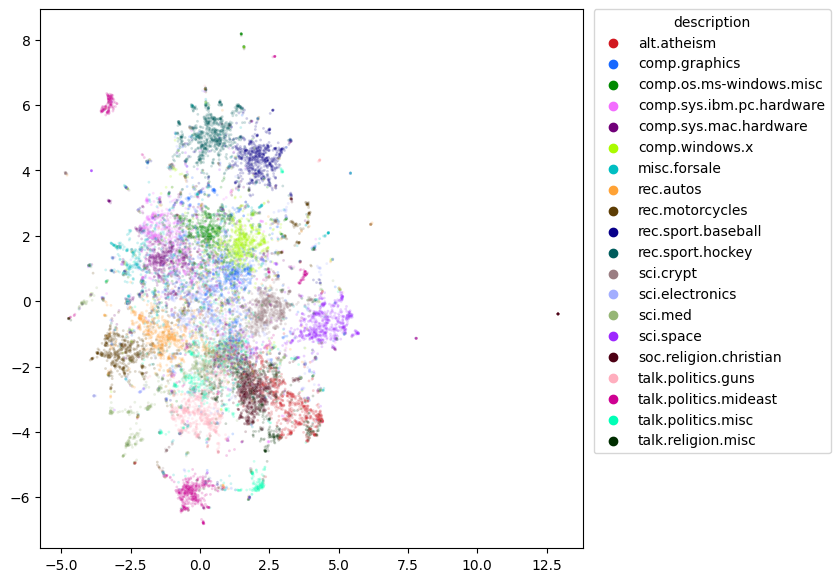

time: 1.65 s (started: 2023-07-17 07:53:07 -07:00)


In [18]:
sns_embed_plot(
    tfidf_coords,
    color_col=codes_to_categories(
        newsgroups_vectorized.target,
        newsgroups_vectorized.target_names,
        col_name="description",
    ),
    cex=4,
    alpha_scale=0.2,
    legend="force",
    figsize=(7, 7),
)

As much as I was rooting for the NCD approach, I'd say this looks better.